# Cats vs Dogs

##### Step 1 - Import relevant libraries

In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile, copy
import math as m
import shutil

##### Step 2 - Download cats-vs-dogs database 

In [6]:
#!wget --no-check-certificate \
    #"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    #-O "/tmp/cats-and-dogs.zip"

local_zip = 'tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp')
zip_ref.close()

In [2]:
print(len(os.listdir('tmp/PetImages/Cat')))
print(len(os.listdir('tmp/PetImages/Dog')))

12501
12501


##### Step 3 - Create folders for training and testing 

In [17]:
try:
    os.mkdir('tmp/cats-v-dogs')
    os.mkdir('tmp/cats-v-dogs/training')
    os.mkdir('tmp/cats-v-dogs/testing')
    os.mkdir('tmp/cats-v-dogs/training/cats')
    os.mkdir('tmp/cats-v-dogs/training/dogs')
    os.mkdir('tmp/cats-v-dogs/testing/cats')
    os.mkdir('tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [16]:
shutil.rmtree('tmp/cats-v-dogs')

##### Step 4 - Divide the database into Training -90%- and Testing -10%- (remove all images that are empty) 

In [3]:
CAT_SOURCE_DIR = "tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "tmp/cats-v-dogs/testing/dogs/"

In [19]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    list_elements = os.listdir(SOURCE)
    list_elements = random.sample(list_elements, len(list_elements))
    training_list = list_elements[0:(m.floor(len(list_elements)*SPLIT_SIZE))]
    test_list = list_elements[(m.floor(len(list_elements)*SPLIT_SIZE))+1:]
    for elem in training_list:
        if os.path.getsize(SOURCE + elem) != 0:  #elements thata are empty are not considered
            copy(SOURCE + elem,TRAINING)
        else:
            print("The element ", elem, "is empty")
            continue
    for elem_t in test_list:
        if os.path.getsize(SOURCE + elem_t) != 0: #elements thata are empty are not considered
            copy(SOURCE + elem_t,TESTING)
        else:
            print("The element ", elem, "is empty")
            continue
            
split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

The element  666.jpg is empty
The element  11702.jpg is empty


In [4]:
print(len(os.listdir('tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('tmp/cats-v-dogs/testing/dogs/')))

11249
11249
1250
1250


In [5]:
train_cat_fnames = os.listdir( TRAINING_CATS_DIR )
train_dog_fnames = os.listdir( TRAINING_DOGS_DIR )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['0.jpg', '1.jpg', '10.jpg', '100.jpg', '10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg', '10005.jpg', '10006.jpg']
['0.jpg', '1.jpg', '10.jpg', '100.jpg', '10000.jpg', '10001.jpg', '10003.jpg', '10004.jpg', '10005.jpg', '10006.jpg']


##### Step 5 - plot part of the database

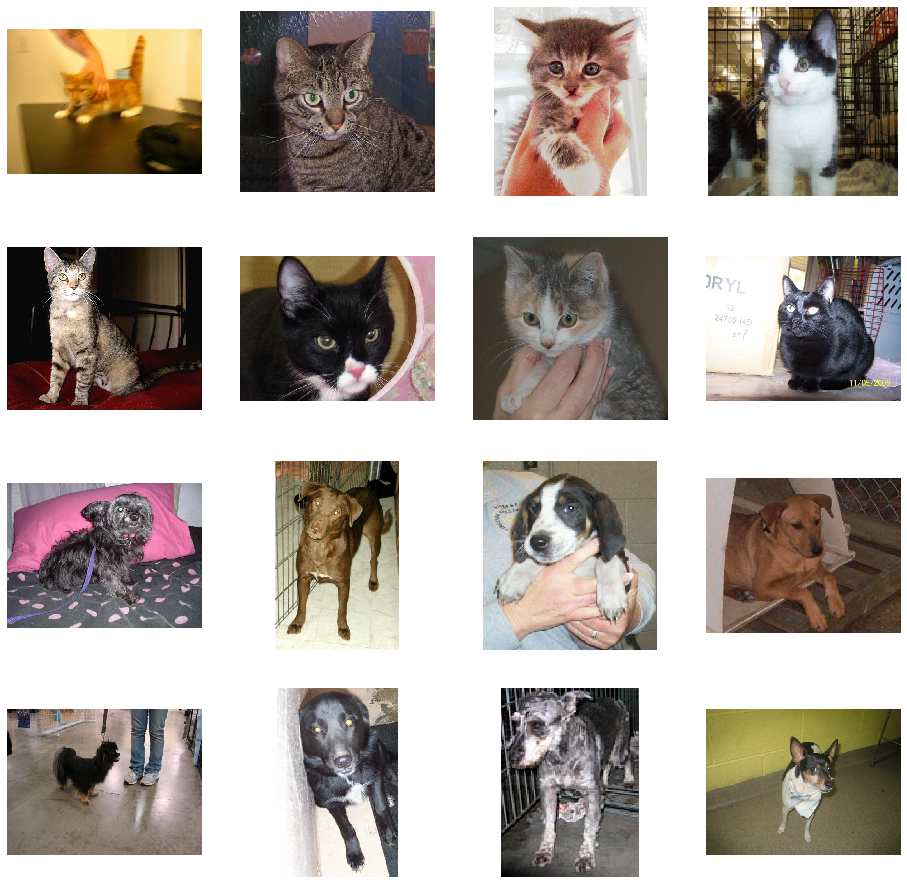

In [6]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images


fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8

next_cat_pix = [os.path.join(TRAINING_CATS_DIR, fname) for fname in train_cat_fnames[pic_index-8:pic_index]]

next_dog_pix = [os.path.join(TRAINING_DOGS_DIR, fname) for fname in train_dog_fnames[pic_index-8:pic_index]]


for i, img_path in enumerate(next_cat_pix + next_dog_pix):
    sp = plt.subplot(nrows, ncols, i+1)
    sp.axis('off')
    
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

##### Step 6 - Create the Model, composed of 3 Convolutions and 3 dense layers

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

##### Step 7 - Compile and fit the model

In [8]:
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [9]:
TRAINING_DIR = 'tmp/cats-v-dogs/training/'
train_datagen = ImageDataGenerator(rescale = 1.0/255.0)

# All images will be rescaled by 1./255
#train_datagen = ImageDataGenerator(
      #rescale=1./255,
      #rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      #horizontal_flip=True,
      #fill_mode='nearest')
# Using data augmentation in this case does not help since there is no overfitting,
# Validation and testing results are comparable

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                   batch_size=10,
                                                   class_mode='binary',
                                                   target_size=(150,150))

VALIDATION_DIR = 'tmp/cats-v-dogs/testing/'
validation_datagen = ImageDataGenerator( rescale = 1.0/255. )
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         batch_size=10,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))#YOUR CODE HERE


Found 22496 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [10]:
history = model.fit(train_generator,
                              epochs=5,
                              verbose=1,
                              validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2250 steps, validate for 250 steps
Epoch 1/5
 812/2250 [=========>....................] - ETA: 3:11 - loss: 0.6673 - acc: 0.6218

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:784: UserWarning: Possibly corrupt EXIF data.  Expecting to r

2250/2250 [==============================] - 309s 137ms/step - loss: 0.6060 - acc: 0.6805 - val_loss: 0.5041 - val_acc: 0.7588
Epoch 2/5
2250/2250 [==============================] - 295s 131ms/step - loss: 0.5029 - acc: 0.7702 - val_loss: 0.4465 - val_acc: 0.8012
Epoch 3/5
2250/2250 [==============================] - 311s 138ms/step - loss: 0.4661 - acc: 0.7910 - val_loss: 0.5569 - val_acc: 0.8188
Epoch 4/5
2250/2250 [==============================] - 312s 139ms/step - loss: 0.4613 - acc: 0.8053 - val_loss: 0.4469 - val_acc: 0.8012
Epoch 5/5
2250/2250 [==============================] - 311s 138ms/step - loss: 0.4423 - acc: 0.8130 - val_loss: 0.4052 - val_acc: 0.8300


##### Step 8 - Plot the results the training and validation

In [11]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Training and validation loss')

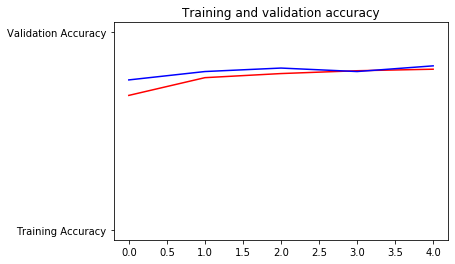

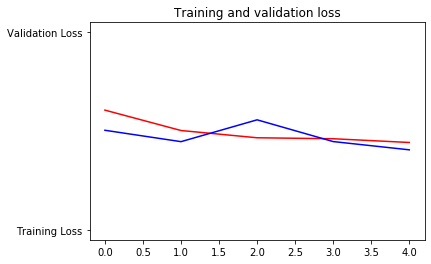

In [12]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.title('Training and validation loss')

##### Step 9 - Test the trained model with custom images

In [13]:
import numpy as np
from tensorflow.keras.preprocessing import image

img = image.load_img('tmp/download (4).jfif', target_size = (150,150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images, batch_size=10)
print(classes[0])
if classes[0]>0.5:
    print("image" + " is a dog")
else:
    print("image" + " is a cat")

[0.]
image is a cat


##### Step 10 - An insight on the intermediate layers of the model

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide


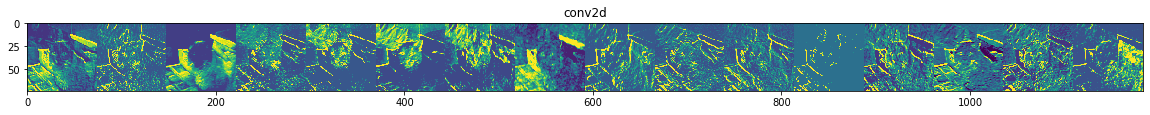

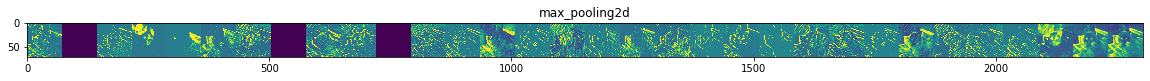

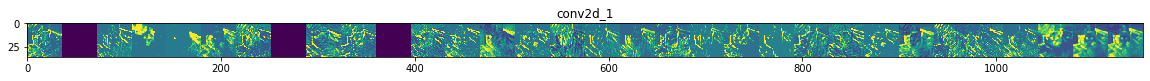

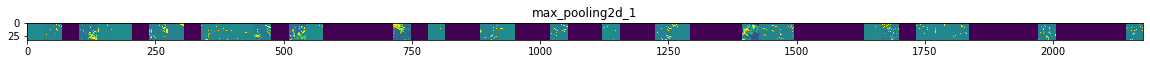

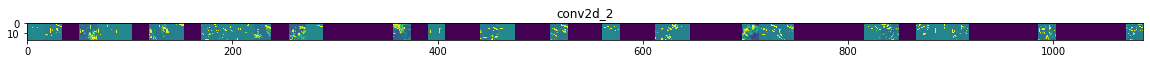

In [14]:
import numpy as np
import random
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
cat_img_files = [os.path.join(TRAINING_CATS_DIR, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(TRAINING_DOGS_DIR, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

Text(0.5, 1.0, 'Training and validation loss')

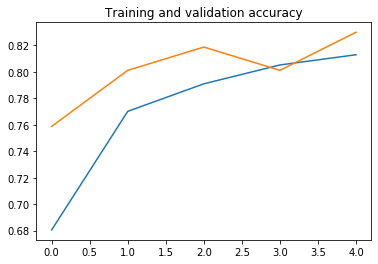

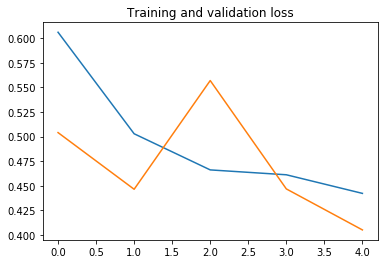

In [15]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'acc' ]
val_acc  = history.history[ 'val_acc' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )